In [ ]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import pickle
from glob import glob
from pprint import pprint

from mejiro.utils import util, lenstronomy_util
from mejiro.instruments.hwo import HWO
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.galaxy_galaxy import SampleBELLS, SampleSL2S, SampleGG

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [5]:
path = os.environ['ROMAN_TECHNICAL_INFORMATION_PATH']
version_path = os.path.join(path, 'VERSION.md')
with open(version_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

print(lines)

version_number = lines[0].strip()

print(version_number)

['1.3.0\n']
1.3.0


0.017188733853924696 arcsec / pix
0.03717923132603912 arcsec2
FWHM in pixels: 2.1630000000000003
<class 'numpy.ndarray'>
Sum of kernel elements: 1.0
Kernel is normalized.


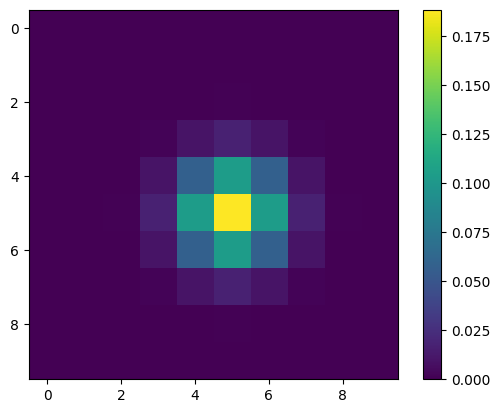

In [13]:
hwo = HWO()

print(hwo.get_pixel_scale('J'))
print(hwo.get_psf_fwhm('J'))

fwhm_in_pixels = hwo.get_psf_fwhm('J') / hwo.get_pixel_scale('J')
print(f'FWHM in pixels: {fwhm_in_pixels.value}')

kernel = util.get_gaussian_kernel(fwhm_in_pixels.value, 10)
print(type(kernel))

print(f"Sum of kernel elements: {np.sum(kernel)}")
print("Kernel is normalized." if np.isclose(np.sum(kernel), 1.0) else "Kernel is NOT normalized.")

plt.imshow(kernel)
plt.colorbar()
plt.show()

In [2]:
from pyHalo.preset_models import preset_model_from_name

strong_lens = SampleGG()
CDM = preset_model_from_name('CDM')
realization = CDM(round(strong_lens.z_lens, 2), round(strong_lens.z_source, 2), cone_opening_angle_arcsec=5)

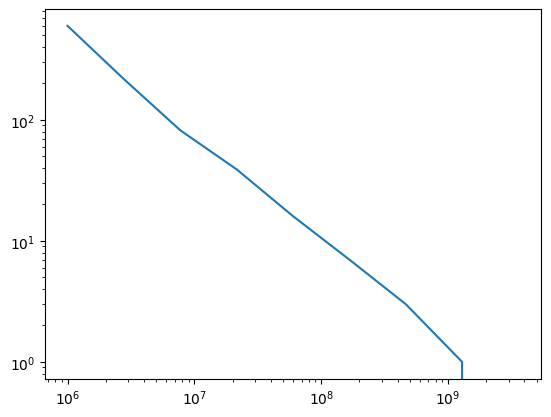

In [3]:
from mejiro.analysis import lensing

plt.loglog(*lensing.get_subhalo_mass_function(realization))
plt.show()

[True, True, True]
['SIE', 'SHEAR', 'CONVERGENCE']
[0.2902115249535011, 0.2902115249535011, 0.2902115249535011]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True,

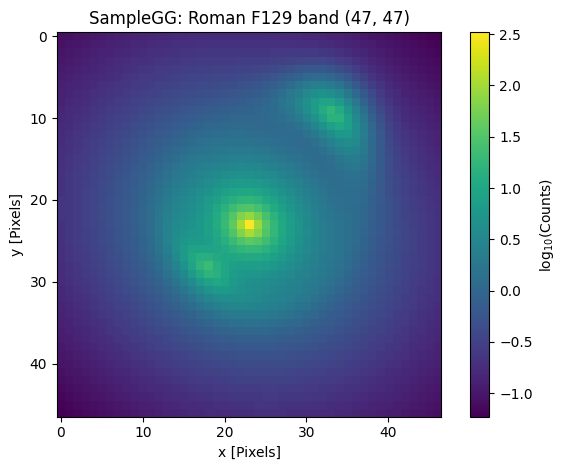

In [4]:
strong_lens = SampleGG()

print(strong_lens.use_jax)
print(strong_lens.lens_model_list)
print(strong_lens.lens_redshift_list)

realization = CDM(round(strong_lens.z_lens, 2), round(strong_lens.z_source, 2), cone_opening_angle_arcsec=5)
strong_lens.add_realization(realization)

print(strong_lens.use_jax)
print(strong_lens.lens_model_list)
print(strong_lens.lens_redshift_list)

synthetic_image = SyntheticImage(strong_lens=strong_lens,
                                     instrument=Roman(),
                                     band='F129',
                                     fov_arcsec=5,
                                     instrument_params={'detector': 'SCA01', 'detector_position': (2048, 2048)},
                                     pieces=False,
                                     verbose=False)
synthetic_image.plot()

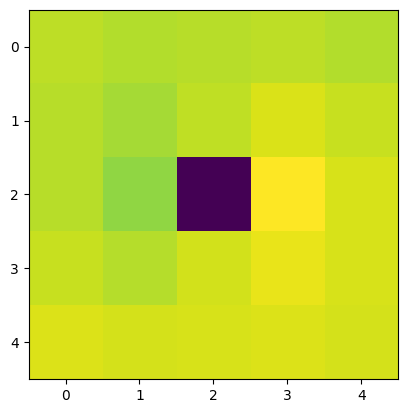

In [9]:
from mejiro.analysis import lensing
from pyHalo.preset_models import preset_model_from_name

strong_lens = SampleBELLS()
CDM = preset_model_from_name('CDM')
realization = CDM(round(strong_lens.z_lens, 2), round(strong_lens.z_source, 2), cone_opening_angle_arcsec=5)
strong_lens.add_realization(realization)

halo_lens_model_list, halo_redshift_array, kwargs_halos, _ = realization.lensing_quantities()
halo_redshift_list = list(halo_redshift_array)

from lenstronomy.LensModel.lens_model import LensModel
halo_lens_model = LensModel(halo_lens_model_list)

_, _, alpha_x, alpha_y = lensing.get_alpha(strong_lens.lens_model, strong_lens.kwargs_lens, 5, 1)

plt.imshow(alpha_x.reshape(5, 5))
plt.show()

In [77]:
strong_lens = SampleSL2S()
image_positions = strong_lens.get_image_positions()
print(image_positions)

(array([0.11436888, 0.51675608]), array([-1.00434361,  0.69127461]))


In [89]:
synthetic_image = SyntheticImage(strong_lens=strong_lens,
                                     instrument=Roman(),
                                     band='F129',
                                     verbose=False)

image_positions = synthetic_image.get_image_positions(pixel=True)
print(image_positions)

(array([24.03971708, 27.69778254]), array([13.86960358, 29.28431467]))


In [104]:
pad = 2

image_radii = []
for x, y in zip(image_positions[0], image_positions[1]):
    image_radii.append(np.sqrt((x - (synthetic_image.num_pix // 2)) ** 2 + (y - (synthetic_image.num_pix // 2)) ** 2))

x = np.linspace(-synthetic_image.num_pix // 2, synthetic_image.num_pix // 2, synthetic_image.num_pix)
y = np.linspace(-synthetic_image.num_pix // 2, synthetic_image.num_pix // 2, synthetic_image.num_pix)
X, Y = np.meshgrid(x, y)
distance = np.sqrt((X - (synthetic_image.strong_lens.kwargs_lens[0]['center_x'] / synthetic_image.pixel_scale)) ** 2 + (
        Y - (synthetic_image.strong_lens.kwargs_lens[0]['center_y'] / synthetic_image.pixel_scale)) ** 2)

min = np.min(image_radii) - pad
if min < 0:
    min = 0
max = np.max(image_radii) + pad
if max > synthetic_image.num_pix // 2:
    max = synthetic_image.num_pix // 2

grid = (distance >= min) & (distance <= max)

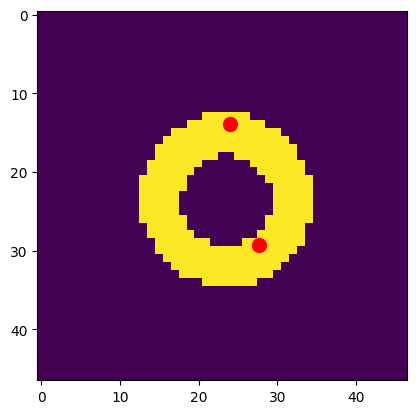

In [105]:
plt.plot(image_positions[0], image_positions[1], 'ro', markersize=10)
plt.imshow(grid)

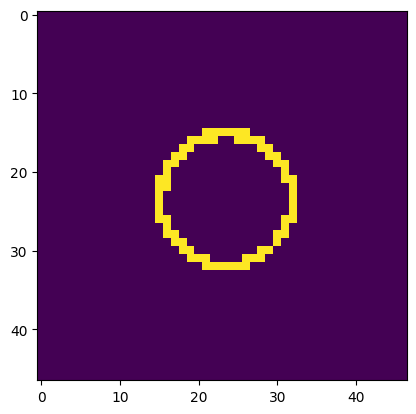

In [95]:
plt.imshow(synthetic_image.build_adaptive_grid(pad=0))

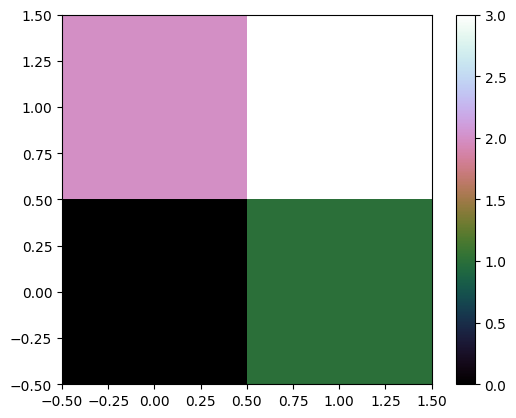

In [35]:
plt.imshow(np.array([[0, 1], [2, 3]]), origin='lower', cmap='cubehelix')
plt.colorbar()
plt.show()

In [2]:
import mejiro
print(os.path.dirname(os.path.dirname(mejiro.__file__)))

/grad/bwedig/mejiro


In [5]:
matplotlib.get_cachedir()

'/grad/bwedig/.cache/matplotlib'

In [6]:
matplotlib.get_configdir()

'/grad/bwedig/.config/matplotlib'

In [5]:
from mejiro.engines import webbpsf_engine

psf_id_string = webbpsf_engine.get_psf_id('F129', 1, (2048, 2048), 1, 47)
webbpsf_engine.cache_psf(psf_id_string, '/grad/bwedig/mejiro/tests/test_data')

Cached PSF to /grad/bwedig/mejiro/tests/test_data/F129_1_2048_2048_1_47.npy


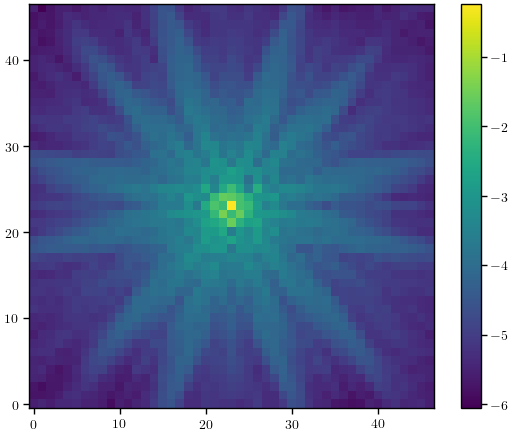

In [6]:
plt.imshow(np.log10(np.load('/grad/bwedig/mejiro/tests/test_data/F129_1_2048_2048_1_47.npy')))
plt.colorbar()
plt.show()

In [3]:
np.nan_to_num(np.array([0]) / np.array([0]))

array([0.])

In [4]:
array = np.array([0, 0, 0])
sum = np.sum(array)
print(array / sum)

[nan nan nan]


In [3]:
ipc_kernel = np.array([[0.001269938, 0.015399776, 0.001199862], \
                       [0.013800177, 1.0, 0.015600367], \
                       [0.001270391, 0.016129619, 0.001200137]])
ipc_kernel /= np.sum(ipc_kernel)

pprint(ipc_kernel)

array([[0.00119146, 0.01444808, 0.00112571],
       [0.01294733, 0.93820048, 0.01463627],
       [0.00119188, 0.01513282, 0.00112597]])


In [20]:
survey_params = util.hydra_to_dict(config.survey)
pipeline_params = util.hydra_to_dict(config.pipeline)

In [21]:
bands = pipeline_params['bands']

In [22]:
runs = survey_params['runs']
scas = survey_params['scas']
pprint(scas)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [28]:
for i in range(runs):
    print(scas[i % len(scas)])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
1
2


In [24]:
bands = bands * 3
print(bands)

['F106', 'F129', 'F184', 'F106', 'F129', 'F184', 'F106', 'F129', 'F184']


In [25]:
results = [np.ones((45, 45))] * len(set(bands)) * 3

In [26]:
print(set(bands))
print(len(set(bands)))

{'F106', 'F184', 'F129'}
3


In [27]:
j = 0
for i, (band, result) in enumerate(zip(bands, results)):
    if j == 0:
        print('array')
    elif j == 1:
        print('lens')
    elif j == 2:
        print('source')
    if i % len(set(bands)) == len(set(bands)) - 1:
        j += 1
    # np.save(os.path.join(output_dir, f'galsim_{lens.uid}_{band}.npy'), result)

array
array
array
lens
lens
lens
source
source
source
